All CSV files loaded successfully.

In-memory SQLite database created.
DataFrames successfully loaded into SQLite tables.

Creating database indexes for performance optimization...
Indexes created successfully.

SQL VIEW 'InventoryChanges' created successfully.
Executing Query 2 (PurchasesByBrand)...
SQL VIEW 'PurchasesByBrand' created successfully in 0.00 seconds.
Executing Query 3 (Final Analysis)...
Analysis complete. Results loaded into a DataFrame in 6.00 seconds.

--- Top 15 Most Profitable Products (Initial View) ---
           InventoryId  Store                   Description  \
0    34_PITMERDEN_1251     34  Port Ellen 32 Yr Single Malt   
1    50_MOUNTMEND_1251     50  Port Ellen 32 Yr Single Malt   
2   66_EANVERNESS_1251     66  Port Ellen 32 Yr Single Malt   
3   67_EANVERNESS_1251     67  Port Ellen 32 Yr Single Malt   
4    73_DONCASTER_1251     73  Port Ellen 32 Yr Single Malt   
5    76_DONCASTER_1251     76  Port Ellen 32 Yr Single Malt   
6   66_EANVERNESS_5795     66

C:\Users\aksab\AppData\Local\Temp\ipykernel_4060\3623720003.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalProfit', y='Description', data=product_performance.head(10), palette='viridis')


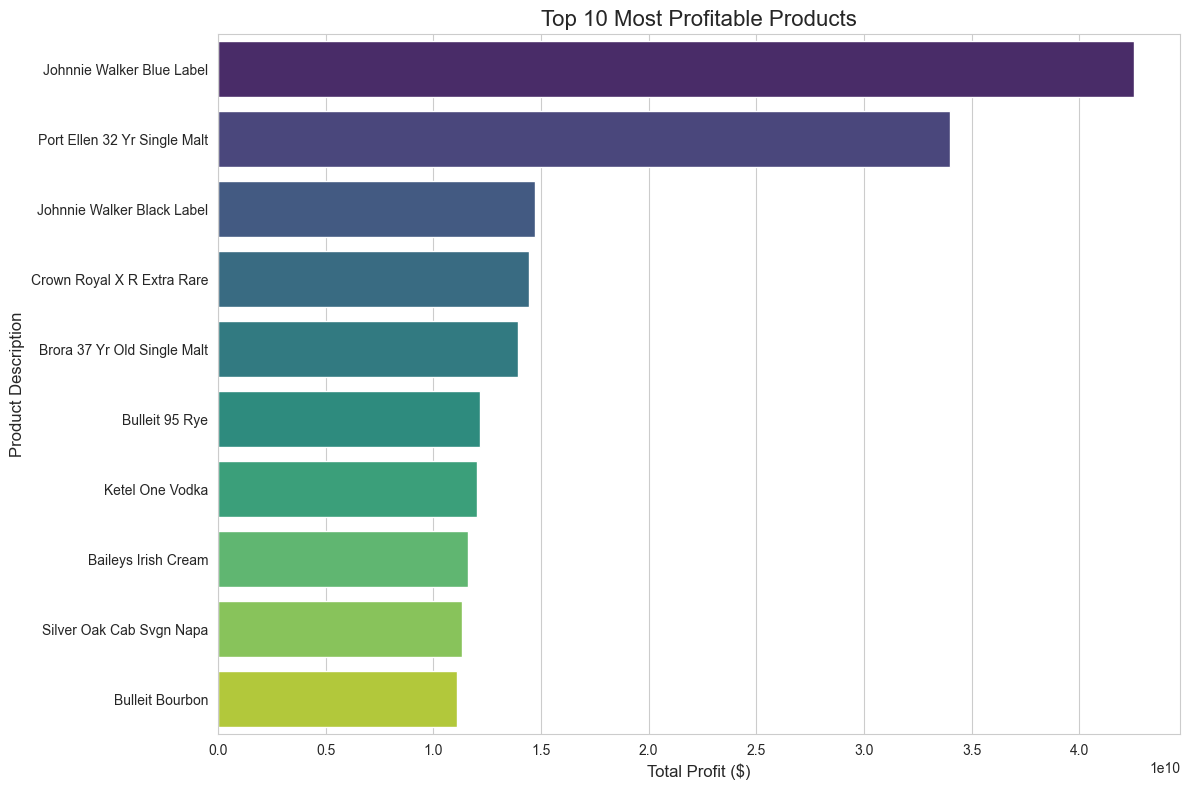


--- Store Performance by City ---
           City  TotalRevenue   TotalProfit    UnitsSold
0    EANVERNESS  5.676895e+11  1.745122e+11  19092125356
1     MOUNTMEND  5.120404e+11  1.595751e+11  21372452412
2     DONCASTER  4.560219e+11  1.444332e+11  14678299280
3       HORNSEY  3.312963e+11  1.014287e+11  15501095272
4     GOULCREST  2.961801e+11  9.310338e+10  11657928024
5     PITMERDEN  2.674779e+11  8.442541e+10   8193597603
6  HARDERSFIELD  1.802553e+11  5.446688e+10   8574771797
7     DRY GULCH  1.480327e+11  4.669198e+10   6405413939
8      WANBORNE  1.405339e+11  4.355627e+10   6035299585
9       IRRAGIN  1.394236e+11  4.266173e+10   5726284311


C:\Users\aksab\AppData\Local\Temp\ipykernel_4060\3623720003.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalProfit', y='City', data=store_performance.head(10), palette='plasma')


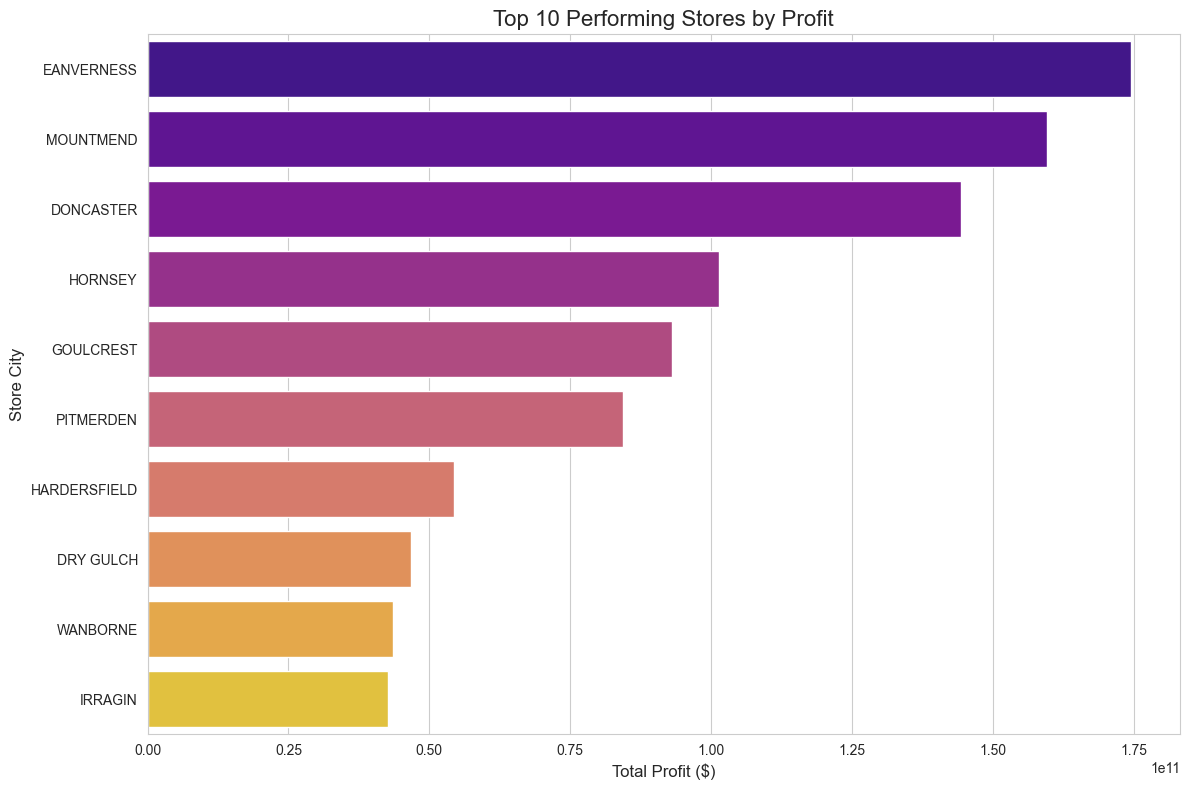


--- Top 10 Vendors by Profitability ---
                    VendorName   TotalProfit
0  DIAGEO NORTH AMERICA INC     7.798478e+11
1        MARTIGNETTI COMPANIES  6.139027e+11
2  JIM BEAM BRANDS COMPANY      2.776860e+11
3  ULTRA BEVERAGE COMPANY LLP   1.832928e+11
4  CONSTELLATION BRANDS INC     1.694581e+11
5  PERNOD RICARD USA            1.323107e+11
6  M S WALKER INC               1.229162e+11
7  E & J GALLO WINERY           1.053916e+11
8  PERFECTA WINES               7.003667e+10
9  BACARDI USA INC              6.180177e+10


C:\Users\aksab\AppData\Local\Temp\ipykernel_4060\3623720003.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalProfit', y='VendorName', data=vendor_performance.head(10), palette='magma')


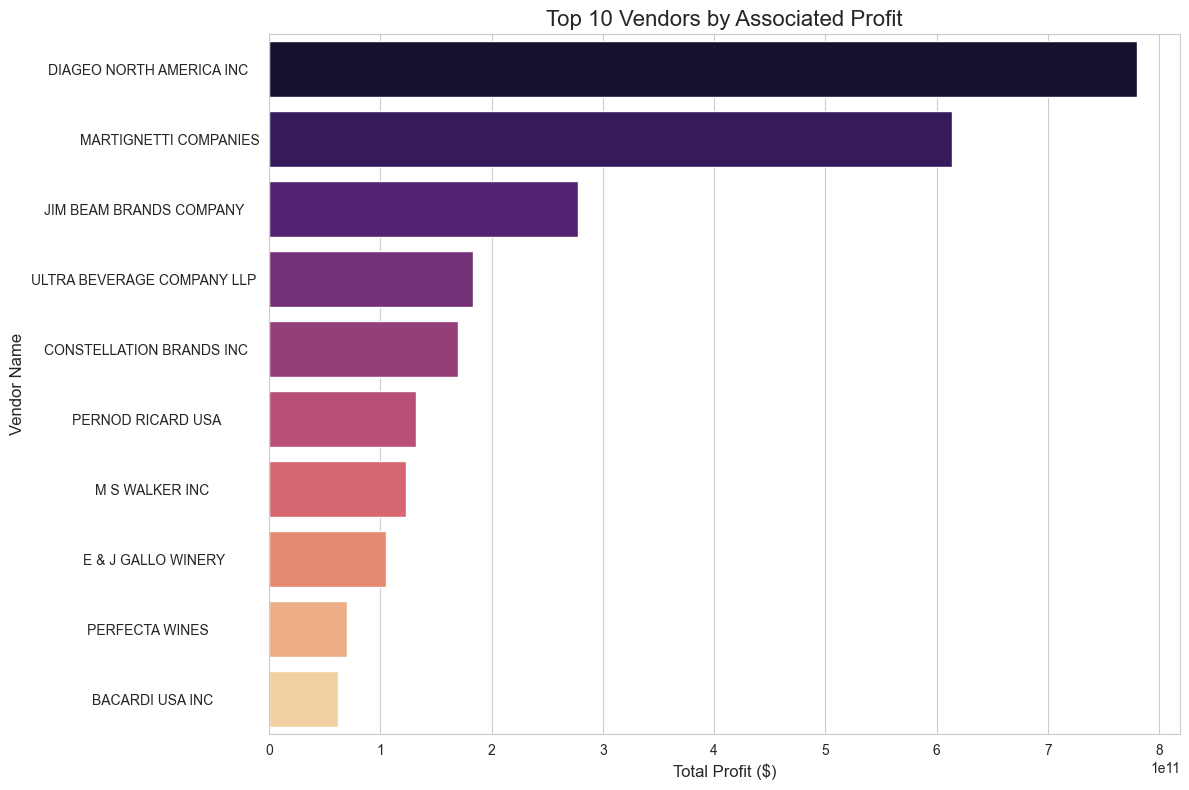

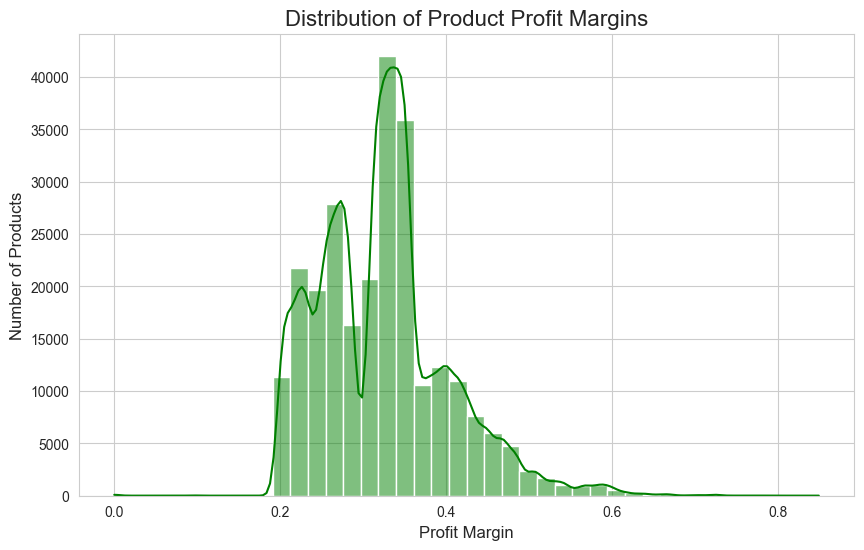


--- Summary of Final Analysis ---
Total number of unique products with sales: 9822
Total Revenue: $9,297,024,956,219.22
Total Profit: $2,818,716,933,909.82

Database connection closed.


In [2]:
# Retail Data Analysis: Sales and Profitability
# SQL analysis done using Python's sqlite3 and pandas libraries.

# --- 1. Setup and Data Loading ---
# First, we'll import the required libraries and load all the source CSV files.

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Set visualization style
sns.set_style("whitegrid")

# Load the data from CSV files
try:
    begin_inventory_df = pd.read_csv('begin_inventory.csv')
    end_inventory_df = pd.read_csv('end_inventory.csv')
    purchase_prices_df = pd.read_csv('purchase_prices.csv')
    vendor_invoice_df = pd.read_csv('vendor_invoice.csv')

    print("All CSV files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Please ensure all CSV files are in the correct directory.")


# --- 2. Create In-Memory SQLite Database ---
# Now, we'll create a temporary database in memory and load our DataFrames into it as SQL tables.

# Create an in-memory SQLite database connection
conn = sqlite3.connect(':memory:')
print("\nIn-memory SQLite database created.")

# Write the data from pandas DataFrames to the SQLite database
begin_inventory_df.to_sql('begin_inventory', conn, index=False, if_exists='replace')
end_inventory_df.to_sql('end_inventory', conn, index=False, if_exists='replace')
purchase_prices_df.to_sql('purchase_prices', conn, index=False, if_exists='replace')
vendor_invoice_df.to_sql('vendor_invoice', conn, index=False, if_exists='replace')

print("DataFrames successfully loaded into SQLite tables.")

# --- 2.1 OPTIMIZATION: Create Indexes ---
# To speed up the JOIN operations in our queries, we create indexes on the key columns.
print("\nCreating database indexes for performance optimization...")
cursor = conn.cursor()
cursor.execute("CREATE INDEX idx_vendor_inv_num ON vendor_invoice (VendorNumber);")
cursor.execute("CREATE INDEX idx_purch_prices_vend_num ON purchase_prices (VendorNumber);")
cursor.execute("CREATE INDEX idx_purch_prices_brand ON purchase_prices (Brand);")
cursor.execute("CREATE INDEX idx_begin_inv_id ON begin_inventory (InventoryId);")
cursor.execute("CREATE INDEX idx_end_inv_id ON end_inventory (InventoryId);")
print("Indexes created successfully.")


# --- 3. Execute SQL Queries ---
# Here, we will execute the three SQL queries to perform the analysis. We first create two 'VIEWS'
# to hold intermediate calculations, then run a final query to get our results.

# --- Query 1: Create InventoryChanges View ---
query_1 = """
CREATE VIEW InventoryChanges AS
SELECT
    COALESCE(bi.InventoryId, ei.InventoryId) AS InventoryId,
    COALESCE(bi.Store, ei.Store) AS Store,
    COALESCE(bi.Brand, ei.Brand) AS Brand,
    COALESCE(bi.Description, ei.Description) AS Description,
    COALESCE(bi.onHand, 0) AS BeginningInventory,
    COALESCE(ei.onHand, 0) AS EndingInventory
FROM
    begin_inventory bi
FULL OUTER JOIN
    end_inventory ei ON bi.InventoryId = ei.InventoryId;
"""
cursor.execute(query_1)
print("\nSQL VIEW 'InventoryChanges' created successfully.")

# --- Query 2: Create PurchasesByBrand View ---
print("Executing Query 2 (PurchasesByBrand)...")
start_time_q2 = time.time()
query_2 = """
CREATE VIEW PurchasesByBrand AS
SELECT
    pp.Brand,
    pp.Description,
    SUM(vi.Quantity) AS TotalQuantityPurchased
FROM
    vendor_invoice vi
JOIN
    purchase_prices pp ON vi.VendorNumber = pp.VendorNumber
GROUP BY
    pp.Brand,
    pp.Description;
"""
cursor.execute(query_2)
end_time_q2 = time.time()
print(f"SQL VIEW 'PurchasesByBrand' created successfully in {end_time_q2 - start_time_q2:.2f} seconds.")


# --- Query 3: Final Sales and Profit Calculation ---
print("Executing Query 3 (Final Analysis)...")
start_time_q3 = time.time()
query_3 = """
SELECT
    ic.InventoryId,
    ic.Store,
    ic.Description,
    ic.BeginningInventory,
    COALESCE(pb.TotalQuantityPurchased, 0) AS QuantityPurchased,
    ic.EndingInventory,
    (ic.BeginningInventory + COALESCE(pb.TotalQuantityPurchased, 0) - ic.EndingInventory) AS UnitsSold,
    pp.Price AS RetailPrice,
    pp.PurchasePrice AS CostPerUnit,
    (ic.BeginningInventory + COALESCE(pb.TotalQuantityPurchased, 0) - ic.EndingInventory) * pp.Price AS TotalRevenue,
    (ic.BeginningInventory + COALESCE(pb.TotalQuantityPurchased, 0) - ic.EndingInventory) * (pp.Price - pp.PurchasePrice) AS TotalProfit,
    pp.VendorName,
    b.City
FROM
    InventoryChanges ic
LEFT JOIN
    PurchasesByBrand pb ON ic.Brand = pb.Brand
LEFT JOIN
    purchase_prices pp ON ic.Brand = pp.Brand
LEFT JOIN
    begin_inventory b ON ic.InventoryId = b.InventoryId
WHERE
    (ic.BeginningInventory + COALESCE(pb.TotalQuantityPurchased, 0) - ic.EndingInventory) > 0
ORDER BY
    TotalProfit DESC;
"""
final_analysis_df = pd.read_sql_query(query_3, conn)
end_time_q3 = time.time()
print(f"Analysis complete. Results loaded into a DataFrame in {end_time_q3 - start_time_q3:.2f} seconds.")


# --- 4. Display Initial Results ---
# Let's look at the top 15 most profitable products from our analysis.

print("\n--- Top 15 Most Profitable Products (Initial View) ---")
print(final_analysis_df.head(15))

# --- 5. Exploratory Data Analysis (EDA) ---
print("\n--- Starting Exploratory Data Analysis ---")

# 5.1 Top Performing Products
product_performance = final_analysis_df.groupby('Description').agg({
    'UnitsSold': 'sum',
    'TotalRevenue': 'sum',
    'TotalProfit': 'sum'
}).sort_values(by='TotalProfit', ascending=False).reset_index()

print("\n--- Top 10 Products by Total Profit ---")
print(product_performance.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='TotalProfit', y='Description', data=product_performance.head(10), palette='viridis')
plt.title('Top 10 Most Profitable Products', fontsize=16)
plt.xlabel('Total Profit ($)', fontsize=12)
plt.ylabel('Product Description', fontsize=12)
plt.tight_layout()
plt.show()

# 5.2 Top Performing Stores
store_performance = final_analysis_df.groupby('City').agg({
    'TotalRevenue': 'sum',
    'TotalProfit': 'sum',
    'UnitsSold': 'sum'
}).sort_values(by='TotalProfit', ascending=False).reset_index()

print("\n--- Store Performance by City ---")
print(store_performance.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='TotalProfit', y='City', data=store_performance.head(10), palette='plasma')
plt.title('Top 10 Performing Stores by Profit', fontsize=16)
plt.xlabel('Total Profit ($)', fontsize=12)
plt.ylabel('Store City', fontsize=12)
plt.tight_layout()
plt.show()

# 5.3 Vendor Analysis
vendor_performance = final_analysis_df.groupby('VendorName').agg({
    'TotalProfit': 'sum'
}).sort_values(by='TotalProfit', ascending=False).reset_index()

print("\n--- Top 10 Vendors by Profitability ---")
print(vendor_performance.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='TotalProfit', y='VendorName', data=vendor_performance.head(10), palette='magma')
plt.title('Top 10 Vendors by Associated Profit', fontsize=16)
plt.xlabel('Total Profit ($)', fontsize=12)
plt.ylabel('Vendor Name', fontsize=12)
plt.tight_layout()
plt.show()

# 5.4 Profitability & Price Analysis
# Avoid division by zero for items with no revenue
final_analysis_df['ProfitMargin'] = (final_analysis_df['TotalProfit'] / final_analysis_df['TotalRevenue']).fillna(0)

plt.figure(figsize=(10, 6))
sns.histplot(final_analysis_df['ProfitMargin'], bins=40, kde=True, color='green')
plt.title('Distribution of Product Profit Margins', fontsize=16)
plt.xlabel('Profit Margin', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.show()

# --- 6. Final Summary ---
print("\n--- Summary of Final Analysis ---")
print(f"Total number of unique products with sales: {final_analysis_df['Description'].nunique()}")
print(f"Total Revenue: ${final_analysis_df['TotalRevenue'].sum():,.2f}")
print(f"Total Profit: ${final_analysis_df['TotalProfit'].sum():,.2f}")

# Close the database connection when done
conn.close()
print("\nDatabase connection closed.")